# TP 4 : données manquantes, détection d'outliers, prédiction de RUL

Dans ce TP, nous travaillerons avec le même genre de données que précédemment, mais cette fois-ci, elles auront été dégradées pour traiter les problématiques proposées.

In [1]:
import pathlib
import numpy as np
import pandas as pd

In [2]:
# Vous trouverez ici les données du TP
filedir = pathlib.Path('data/TP4_inputs')
files = list(filedir.glob('*.csv'))
print(files)

[WindowsPath('data/TP4_inputs/ANR.csv'), WindowsPath('data/TP4_inputs/FOG.csv'), WindowsPath('data/TP4_inputs/HGH.csv')]


# 1 Gestion des données manquantes


1.1. lire les fichiers avec pandas et les concatener. (5'/5')

In [3]:
# Réponse
df_data = pd.concat((pd.read_csv(filename, sep=',', na_filter=True) for filename in files),
                    ignore_index=True, axis=0)
df_data.head()

,AC_REG,CYCLE,TEMP_C°,HUMID_REL_PC(%),THRUST_PC(%),S0D_TMP_SN,S0D_TMP_S2N,S0D_FLP_S3N,S0D_TMP_S4N,S0D_WHL_S5N,...,S2D_PRS_S1N,S1D_TMP_S43N,S34D_TMP_SN,S2D_PGHS_S1N,S0D_RRP_S2N,HOP_FLP_S7N,TEMP_N21,TEMP_N23,TEMP_N32,Company
0,3,1,19.9998,0.7013,0%,491.19,607.76,1486.02,1257.26,"9,35",...,14.6936,0.0,FLO,PPO,0.0,99.0,0.514342,0.702837,0.431706,ANR
1,3,2,20.0071,0.7012,0%,491.19,607.88,1479.31,1248.52,"9,35",...,14.7728,0.0,FLO,PPO,0.0,99.0,1.028685,87.097724,16.112031,ANR
2,3,3,25.0071,0.6213,80%,462.54,536.61,1258.63,1051.53,"7,05",...,8.6033,0.0,FLO,PPO,99.0,1.0,1.543027,2.108512,1.295118,ANR
3,3,4,19.9982,0.7000,0%,491.19,607.72,1486.79,1256.06,"9,35",...,14.6214,0.0,FLO,PPO,0.0,99.0,120.604546,2.811350,1.726823,ANR
4,3,5,0.0003,0.0000,100%,518.67,642.10,1593.30,1408.28,"14,62",...,23.2717,0.0,GGH,PPO,0.0,99.0,120.604546,3.514187,2.158529,ANR


 1.2 Affichez les types des variables du DataFrame et quelques valeurs. Que constatez-vous ? (5'/10')

In [4]:
for k in df_data.keys():
    print(df_data[k].iloc[0:3])

0    3
1    3
2    3
Name: AC_REG, dtype: int64
0    1
1    2
2    3
Name: CYCLE, dtype: int64
0    19.9998
1    20.0071
2    25.0071
Name: TEMP_C°, dtype: float64
0    0.7013
1    0.7012
2    0.6213
Name: HUMID_REL_PC(%), dtype: float64
0     0%
1     0%
2    80%
Name: THRUST_PC(%), dtype: object
0    491.19
1    491.19
2    462.54
Name: S0D_TMP_SN, dtype: object
0    607.76
1    607.88
2    536.61
Name: S0D_TMP_S2N, dtype: float64
0    1486.02
1    1479.31
2    1258.63
Name: S0D_FLP_S3N, dtype: float64
0    1257.26
1    1248.52
2    1051.53
Name: S0D_TMP_S4N, dtype: float64
0    9,35
1    9,35
2    7,05
Name: S0D_WHL_S5N, dtype: object
0    13.65
1    13.66
2     9.02
Name: S0D_WHL_S6N, dtype: float64
0    334.39
1    334.46
2    174.93
Name: S0D_FLP_S7N, dtype: object
0    2323.86
1    2323.89
2    1915.03
Name: S0D_WHL_S8N, dtype: float64
0    8709.62
1    8704.23
2    8003.65
Name: S0D_WHL_S9N, dtype: float64
0    1,08
1    1,08
2    0,94
Name: S1D_TMP_S0N, dtype: object
0    44.3

1.3 Etablisser un dictionnaire des valeurs qui vous semblent devoir être équivalente à NaN. Vous pouvez faire l'hypothèse que les NaN ne commencent pas par un chiffre. (5'/15')

In [5]:
# Réponse
uniques = set([
    str(value)
    for f in list(df_data)
    for value in df_data[f].unique() 
    if str(value)[0] not in '0123456789'
])

print('candidats :', uniques)
na_dict = ['...',
    '/',
    'na',
    'nan',
    'no data'
]
print('filtrage manuel : ', na_dict)

candidats : {'AAD', '/', 'no data', 'GGH', 'nan', 'ANR', 'na', '...', 'FLO', '-99999.0', 'PPO', 'FOG', 'HGH'}
filtrage manuel :  ['...', '/', 'na', 'nan', 'no data']


Les experts métiers nous renseignent que les colonnes suivantes sont numériques :
````python
[
    'AC_REG',
     'CYCLE',
     'TEMP_C°',
     'HUMID_REL_PC(%)',
     'THRUST_PC(%)',
     'S0D_TMP_SN',
     'S0D_TMP_S2N',
     'S0D_FLP_S3N',
     'S0D_TMP_S4N',
     'S0D_WHL_S5N',
     'S0D_WHL_S6N',
     'S0D_FLP_S7N',
     'S0D_WHL_S8N',
     'S0D_WHL_S9N',
     'S1D_TMP_S0N',
     'S1D_TMP_S1N',
     'S1D_FLP_S2N',
     'S1D_FLP_S3N',
     'S1D_TMP_S4N',
     'S1D_PRS_S5N',
     'S1D_PRS_S6N',
     'S1D_TMP_S7N',
     'S1D_TMP_S8N',
     'S1D_TMP_S9N',
     'S2D_PRS_S0N',
     'S2D_PRS_S1N',
     'TEMP_N21', 
     'TEMP_N23', 
     'TEMP_N32'
]
````
1.4 Utilisez cette connaissance pour corriger les problèmes de types dans le jeu de données. (5'/20')

In [6]:
# Réponse
# Ici on remplace les colonnes où les types posaient problème
df_data["S1D_TMP_S0N"] = df_data["S1D_TMP_S0N"].str.replace(',', '.')
df_data["S0D_WHL_S5N"] = df_data["S0D_WHL_S5N"].str.replace(',', '.')
df_data["THRUST_PC(%)"] = df_data["THRUST_PC(%)"].str.replace('%', '')

for f in [
    'AC_REG',
     'CYCLE',
     'TEMP_C°',
     'HUMID_REL_PC(%)',
     'THRUST_PC(%)',
     'S0D_TMP_SN',
     'S0D_TMP_S2N',
     'S0D_FLP_S3N',
     'S0D_TMP_S4N',
     'S0D_WHL_S5N',
     'S0D_WHL_S6N',
     'S0D_FLP_S7N',
     'S0D_WHL_S8N',
     'S0D_WHL_S9N',
     'S1D_TMP_S0N',
     'S1D_TMP_S1N',
     'S1D_FLP_S2N',
     'S1D_FLP_S3N',
     'S1D_TMP_S4N',
     'S1D_PRS_S5N',
     'S1D_PRS_S6N',
     'S1D_TMP_S7N',
     'S1D_TMP_S8N',
     'S1D_TMP_S9N',
     'S2D_PRS_S0N',
     'S2D_PRS_S1N',
     'TEMP_N21', 
     'TEMP_N23', 
     'TEMP_N32'
]: 
    df_data[f] = df_data[f].replace(na_dict, np.nan).astype(float)

df_data.keys()
# Pour les variables categorielles, on peut laisser nan, qui sera alors une catégorie à part.

Index(['AC_REG', 'CYCLE', 'TEMP_C°', 'HUMID_REL_PC(%)', 'THRUST_PC(%)',
       'S0D_TMP_SN', 'S0D_TMP_S2N', 'S0D_FLP_S3N', 'S0D_TMP_S4N',
       'S0D_WHL_S5N', 'S0D_WHL_S6N', 'S0D_FLP_S7N', 'S0D_WHL_S8N',
       'S0D_WHL_S9N', 'S1D_TMP_S0N', 'S1D_TMP_S1N', 'S1D_FLP_S2N',
       'S1D_FLP_S3N', 'S1D_TMP_S4N', 'S1D_PRS_S5N', 'S1D_PRS_S6N',
       'S1D_TMP_S7N', 'S1D_TMP_S8N', 'S1D_TMP_S9N', 'S2D_PRS_S0N',
       'S2D_PRS_S1N', 'S1D_TMP_S43N', 'S34D_TMP_SN', 'S2D_PGHS_S1N',
       'S0D_RRP_S2N', 'HOP_FLP_S7N', 'TEMP_N21', 'TEMP_N23', 'TEMP_N32',
       'Company'],
      dtype='object')

In [7]:
uniques = set([
    str(value)
    for f in list(df_data)
    for value in df_data[f].unique() 
    if str(value)[0] not in '0123456789'
])

print('verification:', uniques)

verification: {'AAD', 'GGH', 'nan', 'ANR', 'FLO', 'FOG', '-99999.0', 'PPO', 'HGH'}


1.5 Visualisez la fréquence des données manquantes, commentez. (5'/25')

In [8]:
#Réponse
pd.DataFrame(df_data.isna().mean())

,0
AC_REG,0.000000
CYCLE,0.000000
TEMP_C°,0.000000
HUMID_REL_PC(%),0.000000
THRUST_PC(%),0.000000
S0D_TMP_SN,0.015441
S0D_TMP_S2N,0.013894
S0D_FLP_S3N,0.014526
S0D_TMP_S4N,0.014003
S0D_WHL_S5N,0.019949


In [9]:
print(df_data.isna().mean().max())

0.0206890544013241


1.6 Visualisez la position des Nans en utilisant le paquet missingno. Que voyez vous ? (5'/30')

<AxesSubplot:>

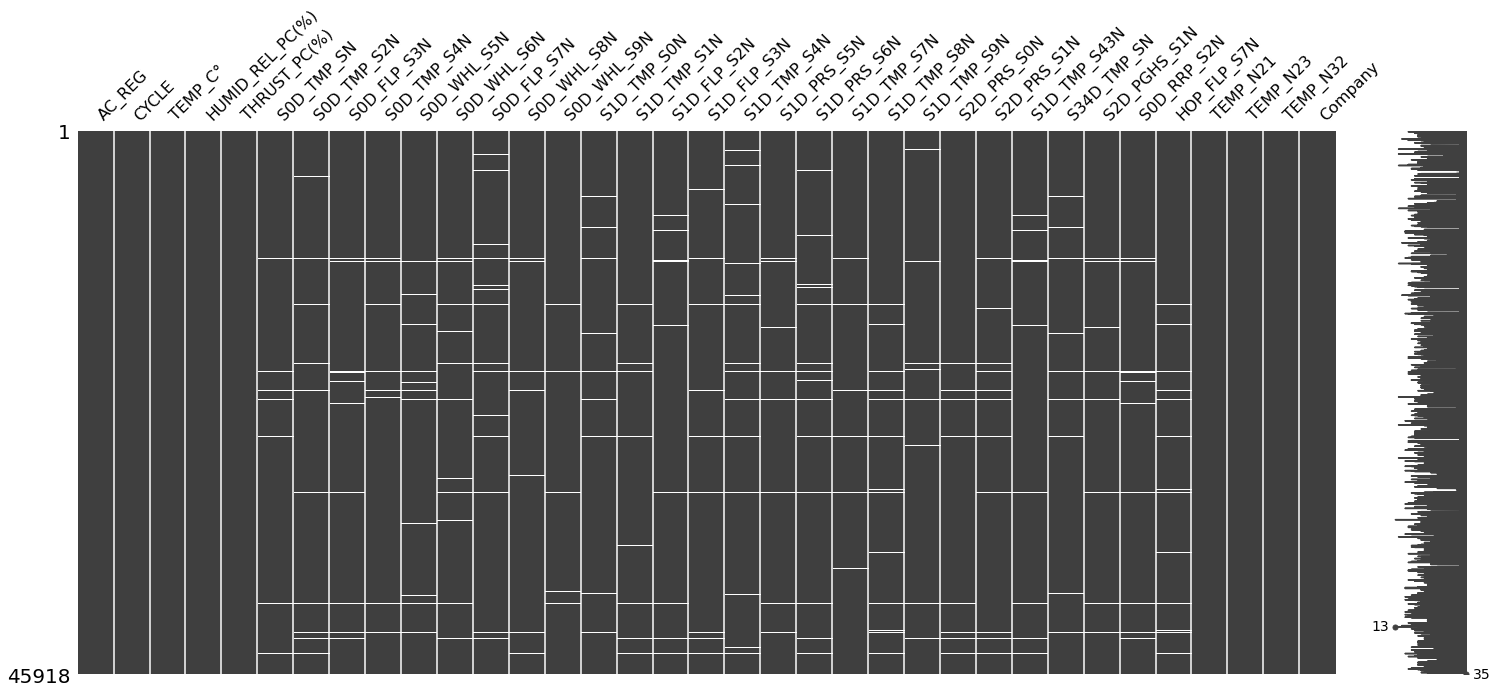

In [10]:
# Réponse
import missingno
missingno.matrix(df_data)

1.7 Retirer les NaN values. Combien de données avez-vous retiré ? Commentez. (5'/35')

In [11]:
# Réponse
df_cleared = pd.DataFrame(df_data.dropna())

In [12]:
print('pourcentage enlevé:', (len(df_data) - len(df_cleared))/len(df_data))

pourcentage enlevé: 0.12210897687181498


# 2 Détection d'outliers
2.1 Utilisez Isolation Forest pour détecter les outliers dans les données numériques. Illustrez vos résultats. (20'/55')

In [13]:
# Réponse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns

list_numeric = []
for k in df_data.keys():
    if df_data[k].dtype != 'object':
        list_numeric.append(k)

myRIF = IsolationForest(n_estimators=500, contamination=0.1)
df_cleared.loc[:, '_isoutlier'] = myRIF.fit_predict(np.array(df_cleared.loc[:, list_numeric]))

print(f"anomaly percent : {100*(df_cleared.loc[:, '_isoutlier']==-1).mean()} %")

anomaly percent : 9.99975192875394 %


C:\Users\d559009\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


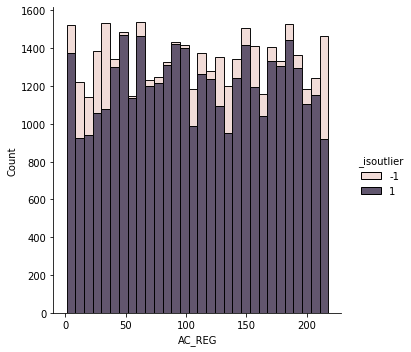

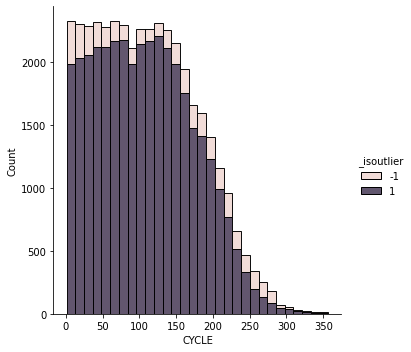

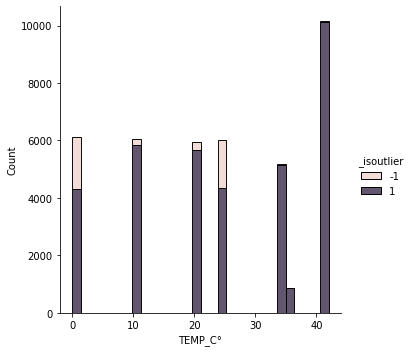

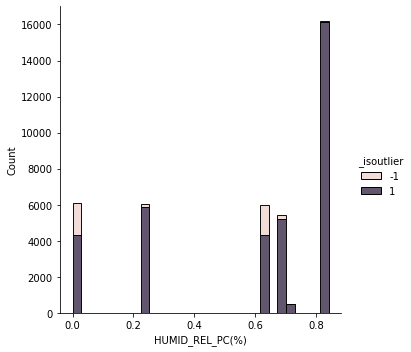

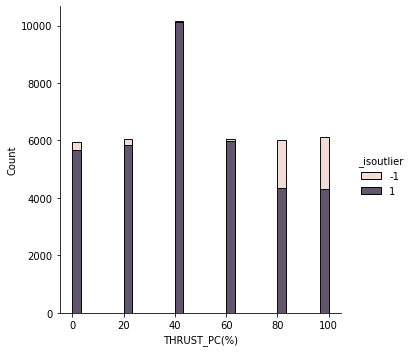

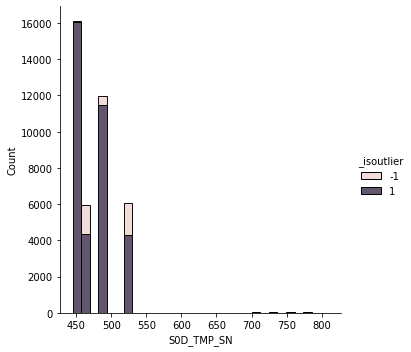

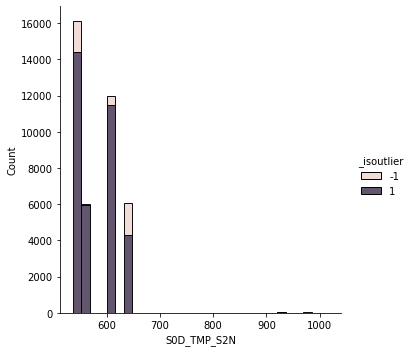

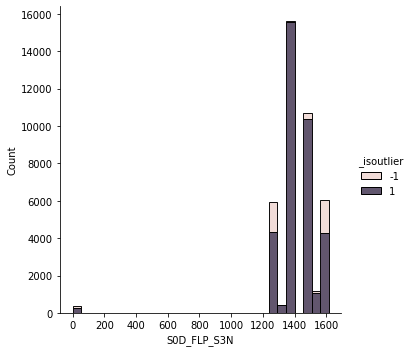

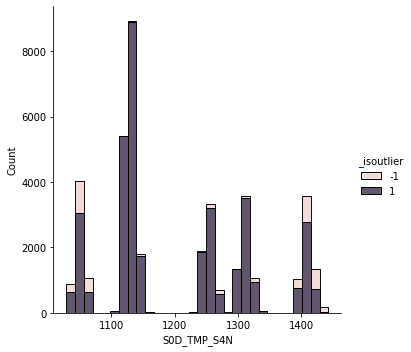

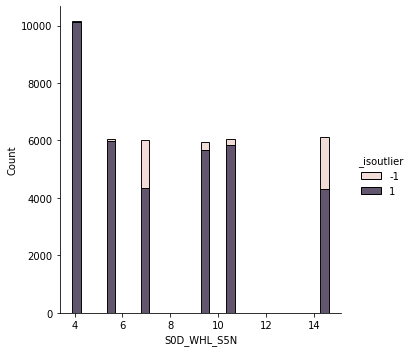

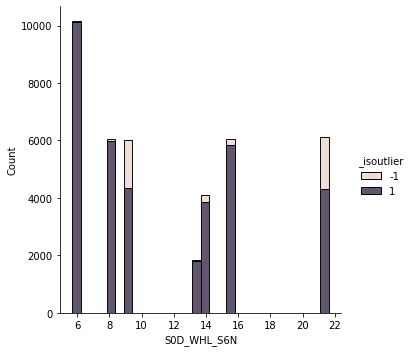

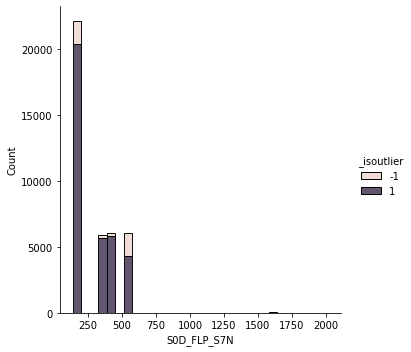

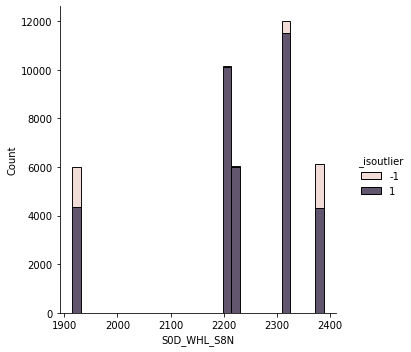

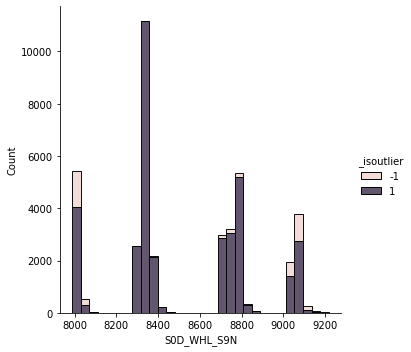

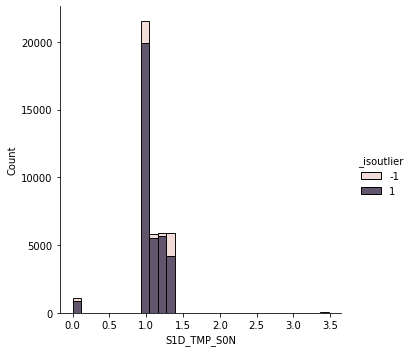

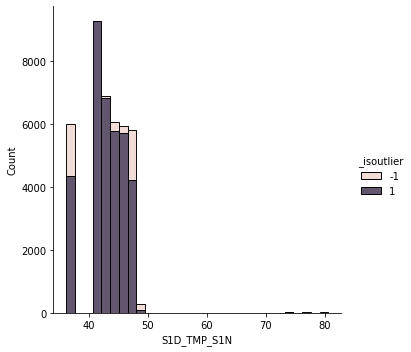

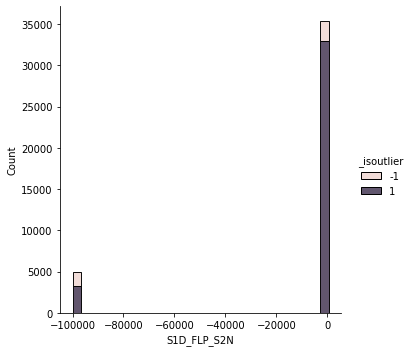

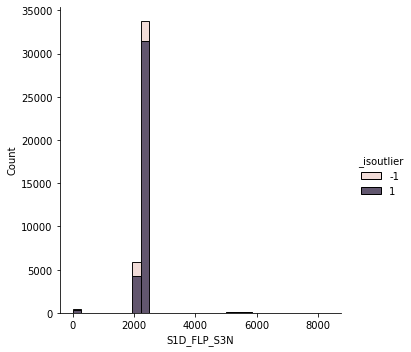

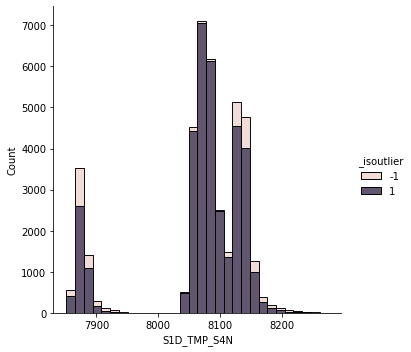

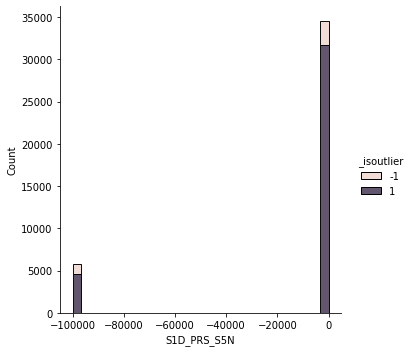

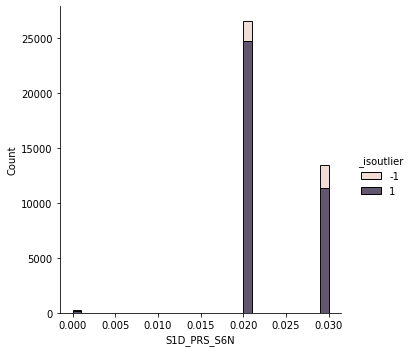

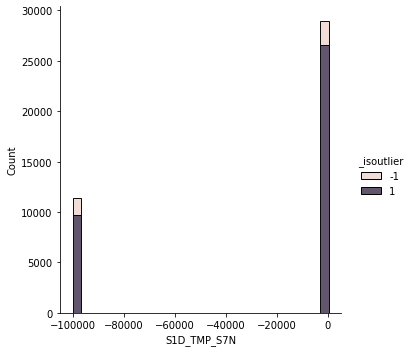

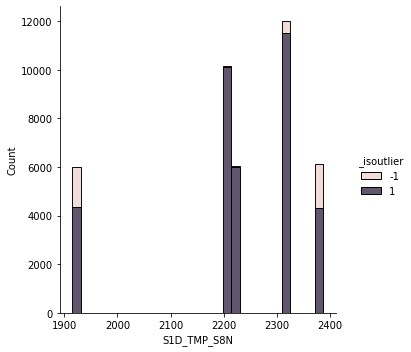

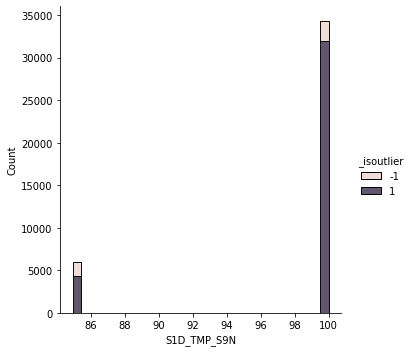

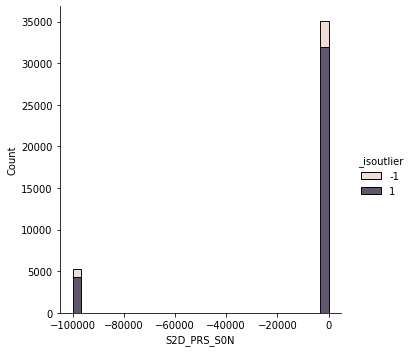

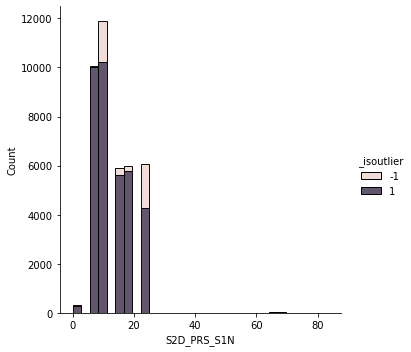

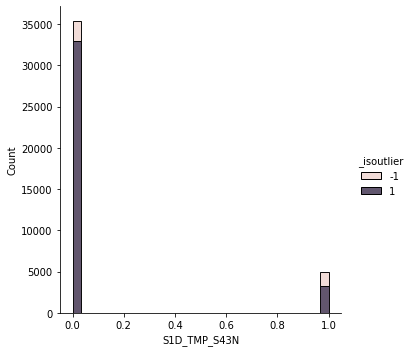

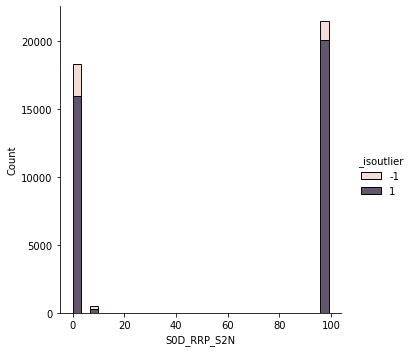

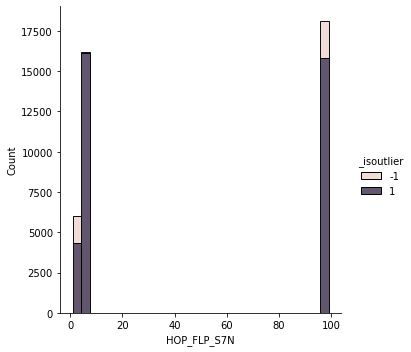

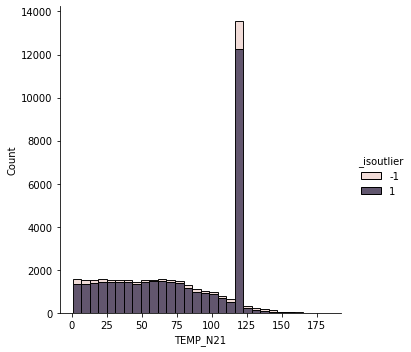

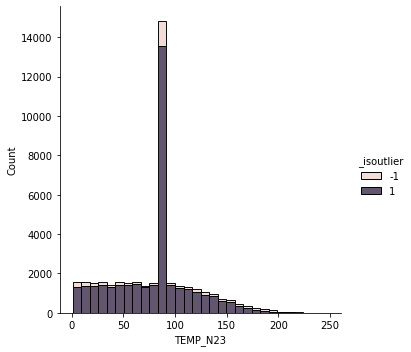

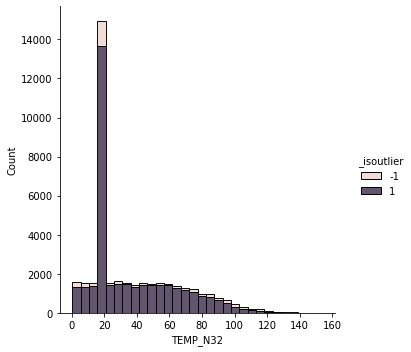

In [14]:
for k in list_numeric:
    sns.displot(data=df_cleared, x=k, hue='_isoutlier', kind='hist', bins=30, multiple="stack")

In [15]:
df_cleared.keys()

Index(['AC_REG', 'CYCLE', 'TEMP_C°', 'HUMID_REL_PC(%)', 'THRUST_PC(%)',
       'S0D_TMP_SN', 'S0D_TMP_S2N', 'S0D_FLP_S3N', 'S0D_TMP_S4N',
       'S0D_WHL_S5N', 'S0D_WHL_S6N', 'S0D_FLP_S7N', 'S0D_WHL_S8N',
       'S0D_WHL_S9N', 'S1D_TMP_S0N', 'S1D_TMP_S1N', 'S1D_FLP_S2N',
       'S1D_FLP_S3N', 'S1D_TMP_S4N', 'S1D_PRS_S5N', 'S1D_PRS_S6N',
       'S1D_TMP_S7N', 'S1D_TMP_S8N', 'S1D_TMP_S9N', 'S2D_PRS_S0N',
       'S2D_PRS_S1N', 'S1D_TMP_S43N', 'S34D_TMP_SN', 'S2D_PGHS_S1N',
       'S0D_RRP_S2N', 'HOP_FLP_S7N', 'TEMP_N21', 'TEMP_N23', 'TEMP_N32',
       'Company', '_isoutlier'],
      dtype='object')

2.2 Utilisez une détection par quantiles pour trouver des outliers (utilisez la méthode basée sur l'écart interquantile IQR). Commentez. (25'/1h15') 

In [16]:
# Réponse
Q1 = df_cleared.loc[:, list_numeric].quantile(0.25)
Q3 = df_cleared.loc[:, list_numeric].quantile(0.75)
IQR = Q3 - Q1
df_cleared['_isoutlier_q'] = ((df_cleared.loc[:, list_numeric] < (Q1 - 1.5 * IQR)) 
                              | (df_cleared.loc[:, list_numeric] > (Q3 + 1.5 * IQR))).any(axis=1)
print(np.mean(df_cleared['_isoutlier_q']))

0.5323112797995584


C:\Users\d559009\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


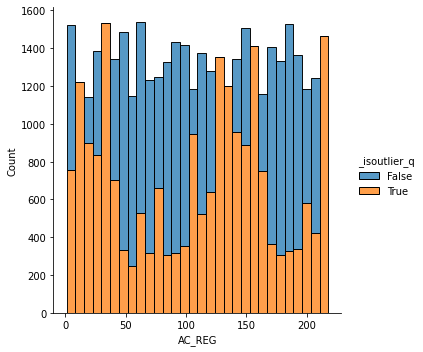

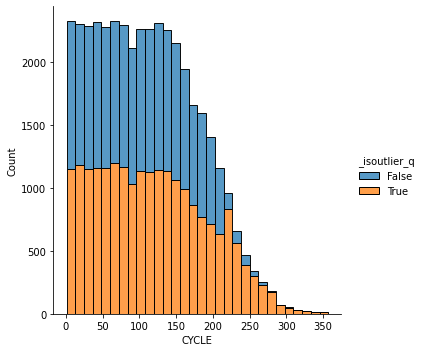

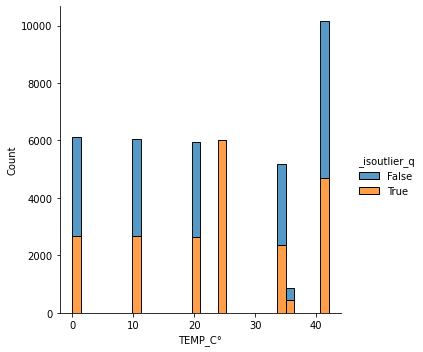

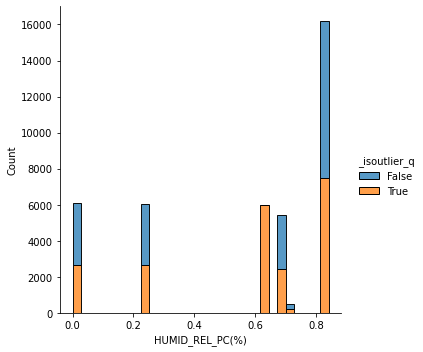

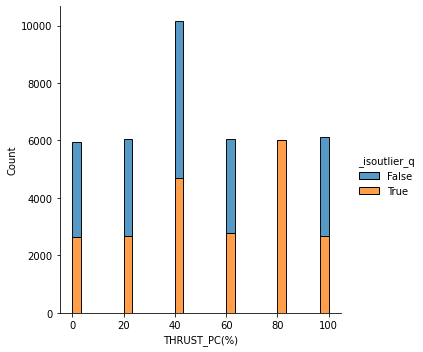

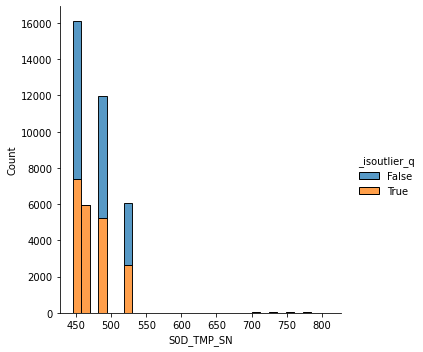

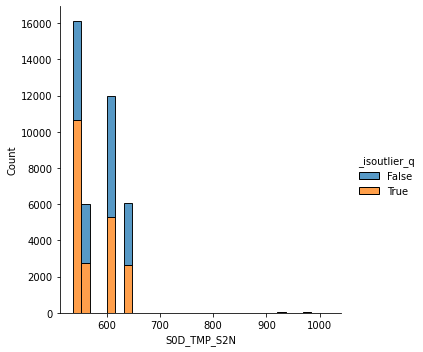

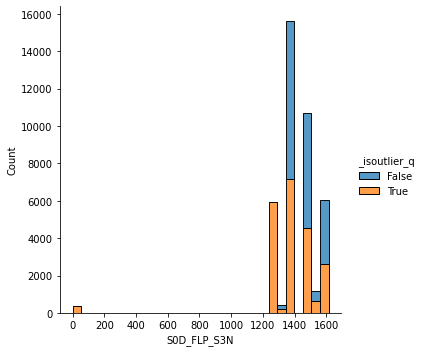

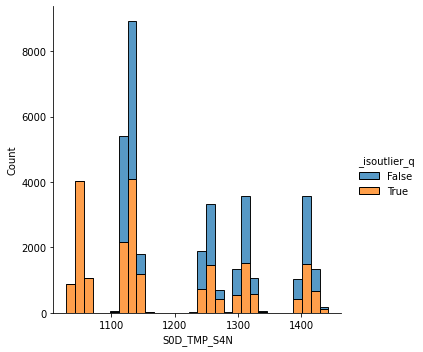

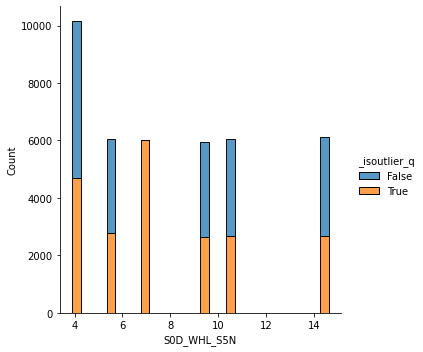

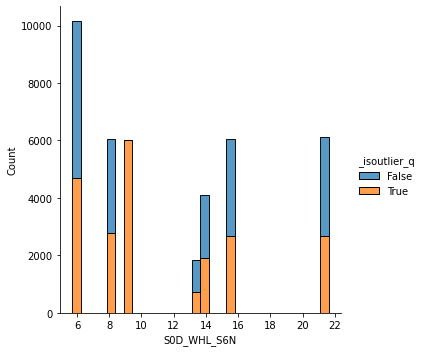

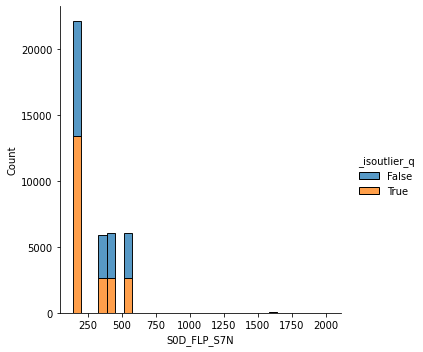

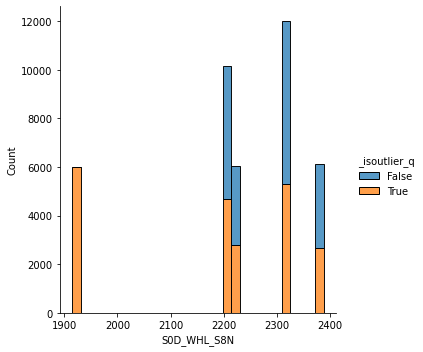

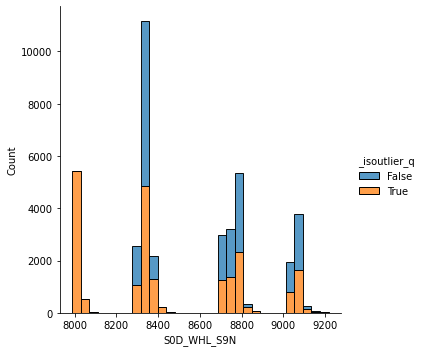

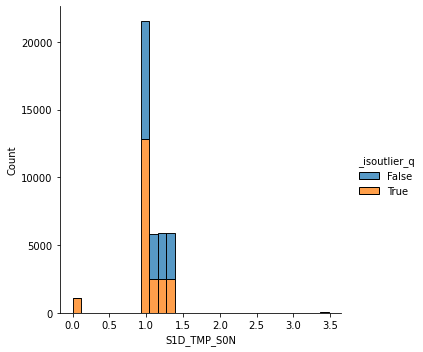

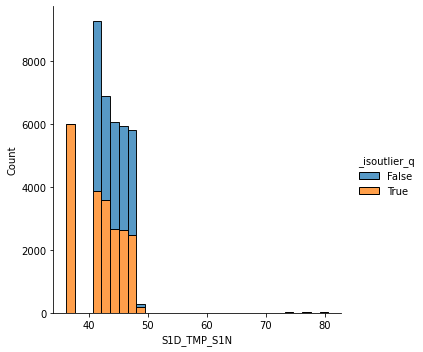

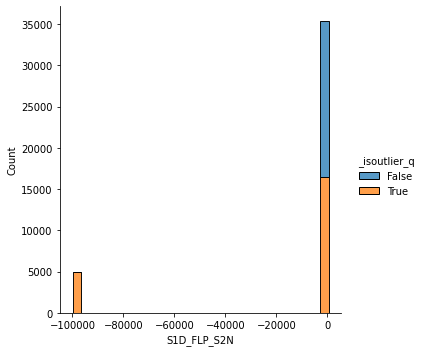

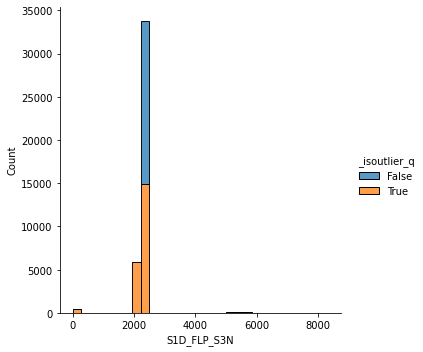

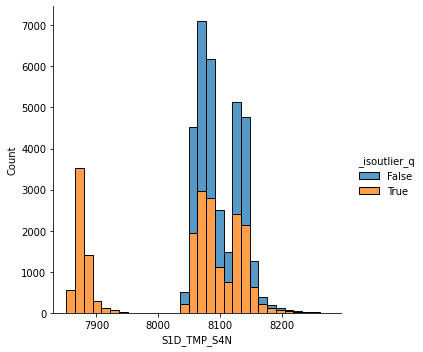

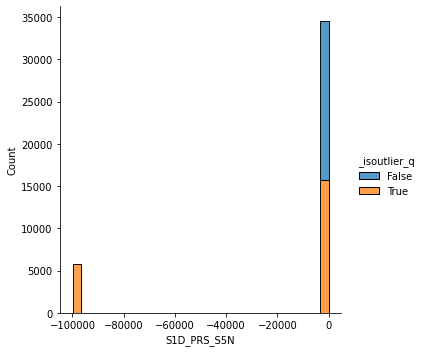

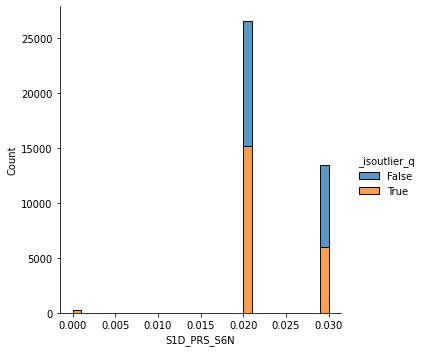

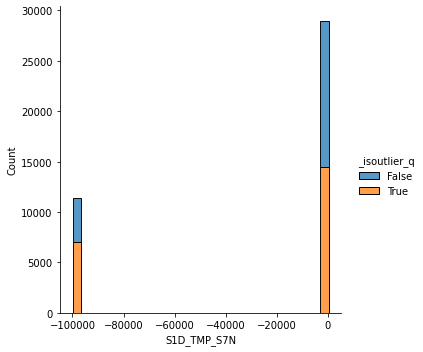

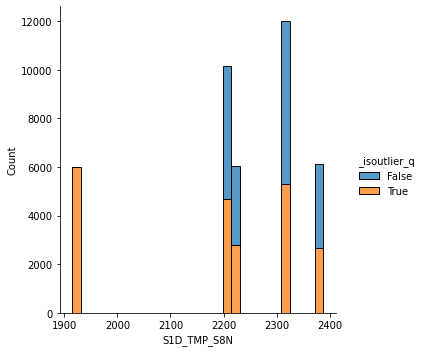

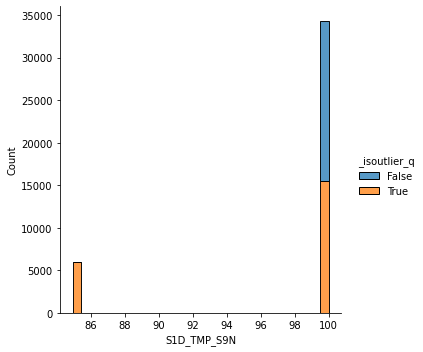

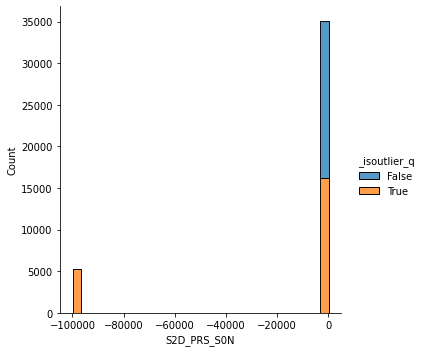

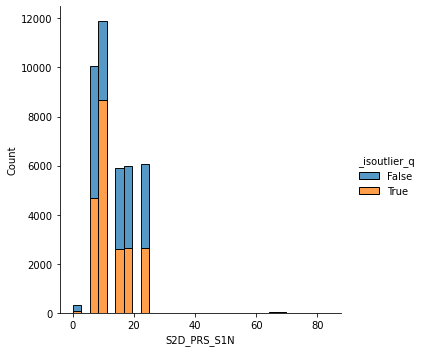

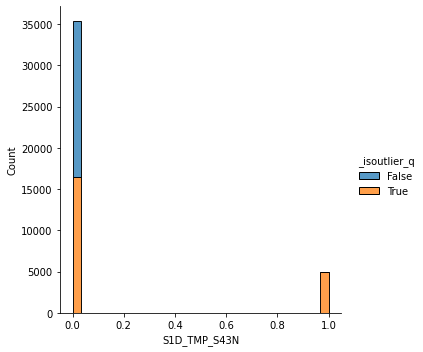

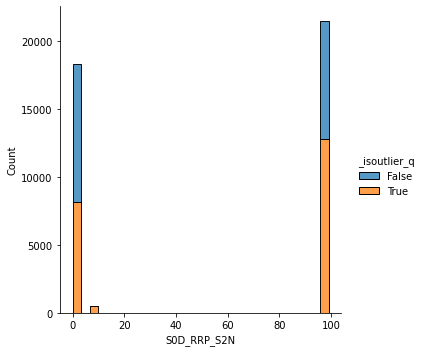

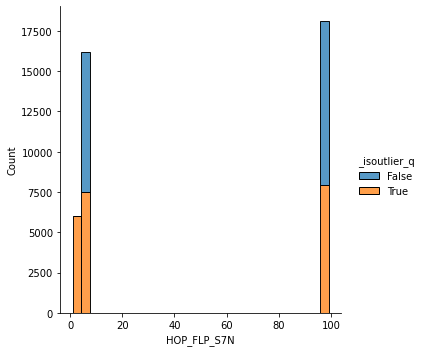

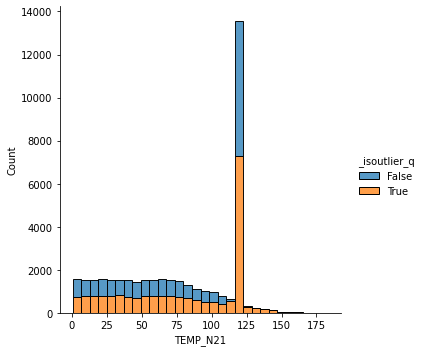

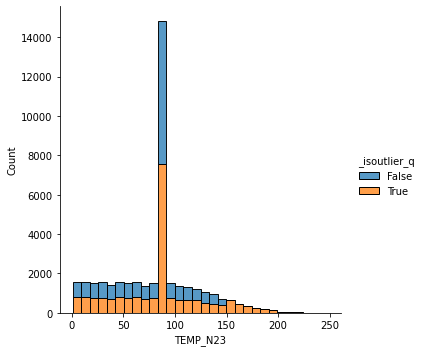

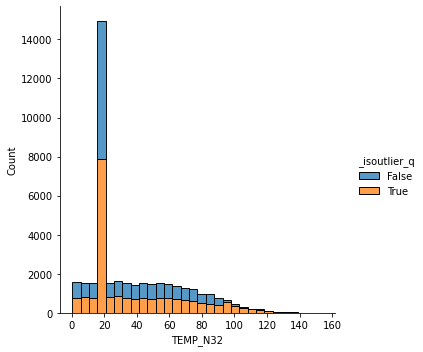

In [17]:
for k in list_numeric:
    sns.displot(data=df_cleared, x=k, hue='_isoutlier_q', kind='hist', bins=30, multiple="stack")

# 3 RUL prediction
3.1 Utilisez pd.to_dummies pour 1-hot encoder les valeur categorielles. (5'/1h20')

In [18]:
cats = [col for col in df_cleared if col not in list_numeric + ['_isoutlier', '_isoutlier_q']]
cats

['S34D_TMP_SN', 'S2D_PGHS_S1N', 'Company']

In [19]:
pd.get_dummies(df_cleared[cats], prefix=cats).head()

,S34D_TMP_SN_AAD,S34D_TMP_SN_FLO,S34D_TMP_SN_GGH,S34D_TMP_SN_PPO,S2D_PGHS_S1N_AAD,S2D_PGHS_S1N_PPO,Company_ANR,Company_FOG,Company_HGH
0,0,1,0,0,0,1,1,0,0
1,0,1,0,0,0,1,1,0,0
2,0,1,0,0,0,1,1,0,0
3,0,1,0,0,0,1,1,0,0
4,0,0,1,0,0,1,1,0,0


In [20]:
df_cleared_one_hot = pd.concat((df_cleared, pd.get_dummies(df_cleared[cats], prefix=cats)),
                               axis=1)
df_cleared_one_hot.head().T

,0,1,2,3,4
AC_REG,3,3,3,3,3
CYCLE,1,2,3,4,5
TEMP_C°,19.9998,20.0071,25.0071,19.9982,0.0003
HUMID_REL_PC(%),0.7013,0.7012,0.6213,0.7,0
THRUST_PC(%),0,0,80,0,100
S0D_TMP_SN,491.19,491.19,462.54,491.19,518.67
S0D_TMP_S2N,607.76,607.88,536.61,607.72,642.1
S0D_FLP_S3N,1486.02,1479.31,1258.63,1486.79,1593.3
S0D_TMP_S4N,1257.26,1248.52,1051.53,1256.06,1408.28
S0D_WHL_S5N,9.35,9.35,7.05,9.35,14.62


In [21]:
# Vérification des types
for key, dtype in zip(df_cleared_one_hot.keys(), df_cleared_one_hot.dtypes):
    print(key, dtype)

AC_REG float64
CYCLE float64
TEMP_C° float64
HUMID_REL_PC(%) float64
THRUST_PC(%) float64
S0D_TMP_SN float64
S0D_TMP_S2N float64
S0D_FLP_S3N float64
S0D_TMP_S4N float64
S0D_WHL_S5N float64
S0D_WHL_S6N float64
S0D_FLP_S7N float64
S0D_WHL_S8N float64
S0D_WHL_S9N float64
S1D_TMP_S0N float64
S1D_TMP_S1N float64
S1D_FLP_S2N float64
S1D_FLP_S3N float64
S1D_TMP_S4N float64
S1D_PRS_S5N float64
S1D_PRS_S6N float64
S1D_TMP_S7N float64
S1D_TMP_S8N float64
S1D_TMP_S9N float64
S2D_PRS_S0N float64
S2D_PRS_S1N float64
S1D_TMP_S43N float64
S34D_TMP_SN object
S2D_PGHS_S1N object
S0D_RRP_S2N float64
HOP_FLP_S7N float64
TEMP_N21 float64
TEMP_N23 float64
TEMP_N32 float64
Company object
_isoutlier int32
_isoutlier_q bool
S34D_TMP_SN_AAD uint8
S34D_TMP_SN_FLO uint8
S34D_TMP_SN_GGH uint8
S34D_TMP_SN_PPO uint8
S2D_PGHS_S1N_AAD uint8
S2D_PGHS_S1N_PPO uint8
Company_ANR uint8
Company_FOG uint8
Company_HGH uint8


3.2 Créez la liste des features qui serviront à l'entrainement du model. Vous prendrez toutes les colonnes numériques de la dataFrame excepté "CYCLE". Calculez une colonne qui contient la RUL. Etudiez la distribution de la RUL. Commentez. (25'/1h45')

In [22]:
features = [col for col in df_cleared_one_hot.select_dtypes('number').columns 
            if col not in ['CYCLE', 'AC_REG']]
df_cleared_one_hot['RUL'] = df_cleared_one_hot['CYCLE'].copy()
for unit in df_cleared_one_hot['AC_REG'].unique():
    tmp_df = df_cleared_one_hot.loc[df_cleared_one_hot['AC_REG']==unit, 'CYCLE'].copy()
    last_value = tmp_df.iloc[-1]
    indexes = df_cleared_one_hot.loc[:, 'AC_REG']==unit
    all_value = np.array(tmp_df)
    df_cleared_one_hot.loc[indexes, 'RUL'] = all_value - last_value


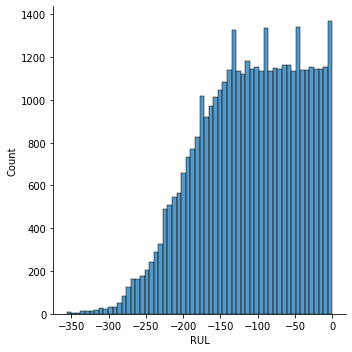

In [24]:
import seaborn as sns

sns.displot(df_cleared_one_hot['RUL'])

3.3 Séparez votre dataset entre un jeu d'entrainement et de test. A votre avis, faut il faire particulierement attention à cette repartition ? Risquons nous de faire survenir des biais ? Apprenez un modèle linéaire sur toutes les données. (10'/1h55')

In [25]:
# Ne pas mélanger les données d'un même avion
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=2)

X = df_cleared_one_hot.loc[:, features]
y = df_cleared_one_hot.loc[:, 'RUL']

for train_index, test_index in gkf.split(X, groups=df_cleared_one_hot['AC_REG']):
     print("TRAIN:", len(train_index), "TEST:", (test_index))

X_train, X_test = X.iloc[train_index,:], X.iloc[test_index, :]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

TRAIN: 20158 TEST: [    0     1     2 ... 40308 40309 40310]
TRAIN: 20153 TEST: [  495   496   497 ... 40047 40048 40049]
(20153, 40) (20158, 40)
(20153,) (20158,)


train score: 0.6026420121127363
test score: 0.6040346499217097


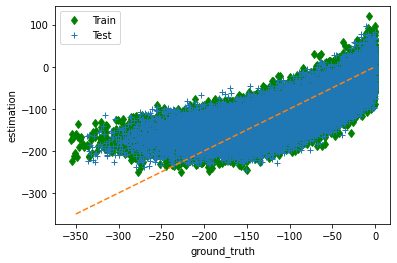

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
print('train score:', model.score(X_train,y_train))
print('test score:', model.score(X_test,y_test))

plt.plot(y_train, model.predict(X_train), 'gd')
plt.plot(y_test, model.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

3.4 Etudiez la correlation entre les features numeriques et la RUL. Commentez. (5'/2h)

Text(0.5, 0, 'TEMP_N21')

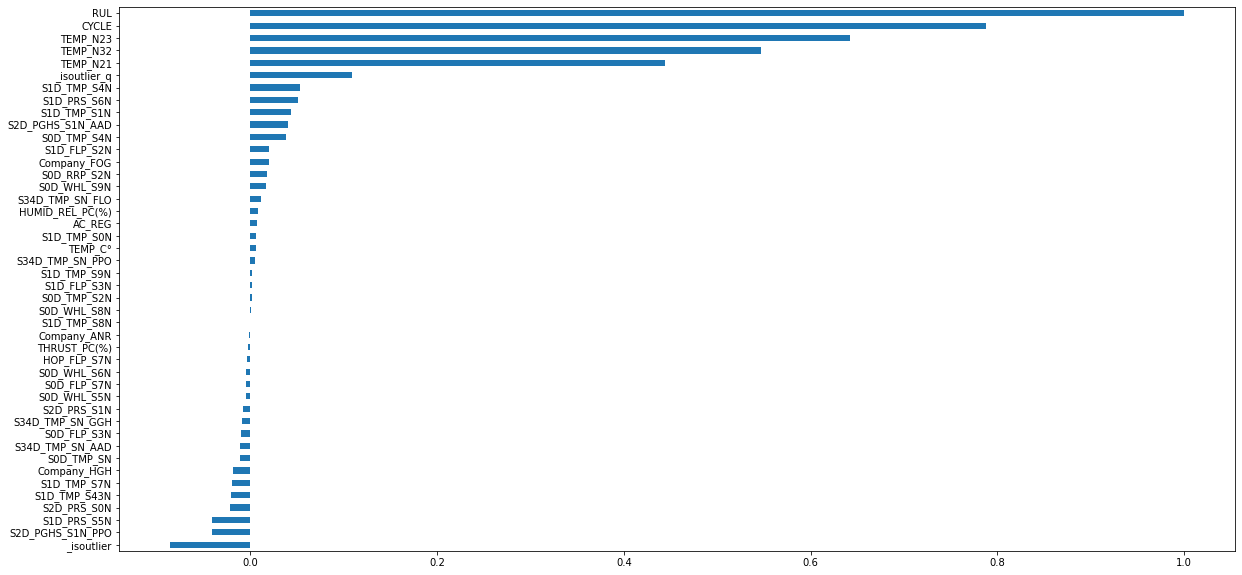

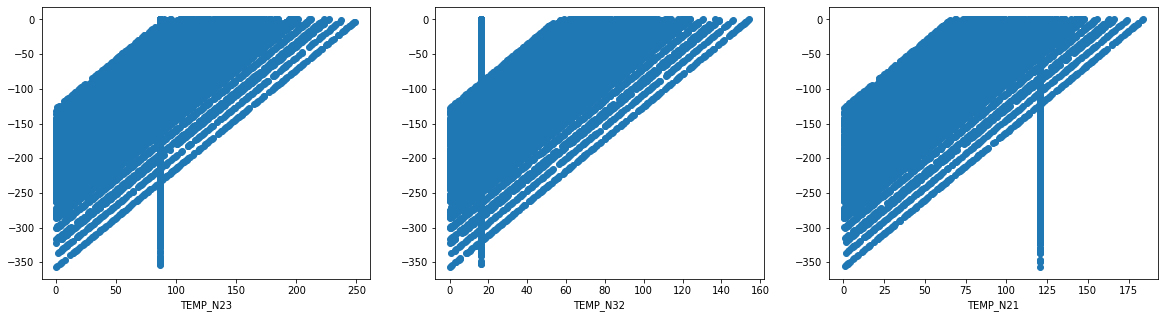

In [27]:
plt.figure(figsize=(20, 10))
df_cleared_one_hot.corr().RUL.sort_values().plot.barh()
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(df_cleared_one_hot.loc[:, ['TEMP_N23']], df_cleared_one_hot.loc[:, ['RUL']])
plt.xlabel('TEMP_N23')
plt.subplot(1, 3, 2)
plt.scatter(df_cleared_one_hot.loc[:, ['TEMP_N32']], df_cleared_one_hot.loc[:, ['RUL']])
plt.xlabel('TEMP_N32')
plt.subplot(1, 3, 3)
plt.scatter(df_cleared_one_hot.loc[:, ['TEMP_N21']], df_cleared_one_hot.loc[:, ['RUL']])
plt.xlabel('TEMP_N21')

train score 0.46978605028412224
test score 0.4842032239428433


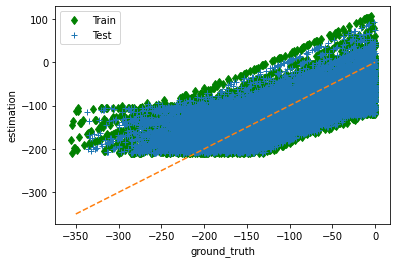

In [28]:
from sklearn.linear_model import LinearRegression
features_selected = ['TEMP_N23', 'TEMP_N32', 'TEMP_N21']

model_selected = LinearRegression()
model_selected.fit(X_train.loc[:, features_selected],
          y_train)

print('train score', model_selected.score(X_train.loc[:, features_selected],y_train))
print('test score', model_selected.score(X_test.loc[:, features_selected],y_test))

plt.plot(y_train, model_selected.predict(X_train.loc[:, features_selected]), 'gd')
plt.plot(y_test, model_selected.predict(X_test.loc[:, features_selected]), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

3.5 Faites de la sélection de features grâce à RFE. (Recursive Feature Elimination). Ne considerez que les valeurs numériques. (5'/2h05')

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [30]:
model = LinearRegression()
rfe = RFE(model,n_features_to_select=5)
model_linear_rfe = rfe.fit(X_train, y_train)

In [31]:
print("Num Features: %s" % (model_linear_rfe.n_features_))
print("Selected Features: %s" % (model_linear_rfe.support_))
print("Feature Ranking: %s" % (model_linear_rfe.ranking_))

for i, name in enumerate(features):
    if model_linear_rfe.support_[i]:
        print(name)

Num Features: 5
Selected Features: [False False False False False False False  True  True False  True False
 False False False False False False  True False  True False False False
 False False False False False False False False False False False False
 False False False False]
Feature Ranking: [ 4  2  9 28 29 32 13  1  1 34  1 23  7 18 30 33 24 16  1 36  1  3 35 26
 19 31 10 27 22 25 20  5  8 17  6 15 11 12 14 21]
S0D_WHL_S5N
S0D_WHL_S6N
S0D_WHL_S8N
S1D_PRS_S6N
S1D_TMP_S8N


train score: 0.11165206714010589
test score: 0.08929032039364193


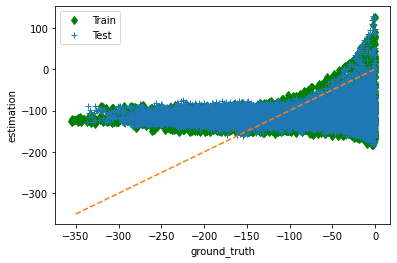

In [32]:
print('train score:', model_linear_rfe.score(X_train, y_train))
print('test score:', model_linear_rfe.score(X_test, y_test))

plt.plot(y_train, model_linear_rfe.predict(X_train), 'gd')
plt.plot(y_test, model_linear_rfe.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

In [33]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [34]:
model = RandomForestRegressor()
rfe = RFE(model,n_features_to_select=5)
model_RF_rfe = rfe.fit(X_train, y_train)

In [35]:
print("Num Features: %s" % (model_RF_rfe.n_features_))
print("Selected Features: %s" % (model_RF_rfe.support_))
print("Feature Ranking: %s" % (model_RF_rfe.ranking_))

for i, name in enumerate(features):
    if model_RF_rfe.support_[i]:
        print(name)

Num Features: 5
Selected Features: [False False False False False False  True False False False False False
 False  True False False False False False False False False False False
 False False False  True  True  True False False False False False False
 False False False False]
Feature Ranking: [12 15 25 28  9 11  1 32 22  6 13  7 18  1  4  2  5  3 20 14 31 36  8 10
 21 30 35  1  1  1 24 23 29 33 34 26 27 19 17 16]
S0D_TMP_S4N
S1D_TMP_S1N
TEMP_N21
TEMP_N23
TEMP_N32


train score: 0.9527566426709636
test score: 0.6923673705908397


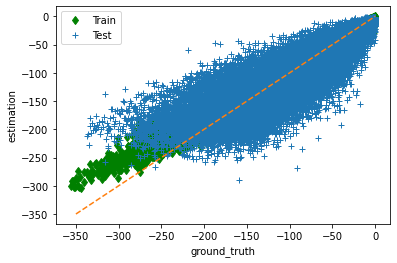

In [36]:
print('train score:', model_RF_rfe.score(X_train, y_train))
print('test score:', model_RF_rfe.score(X_test, y_test))

plt.plot(y_train, model_RF_rfe.predict(X_train), 'gd')
plt.plot(y_test, model_RF_rfe.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

3.6 Apprenez un LASSO et comparez. (10'/2h15')

In [37]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(max_iter=25000, alpha=5.0)
lasso_model.fit(X_train, y_train)

Lasso(alpha=5.0, max_iter=25000)

In [38]:
for i, name in enumerate(features):
    if np.abs(lasso_model.coef_[i]) > 0.0:
        print(name, lasso_model.coef_[i])

THRUST_PC(%) -2.125804885842765
S0D_TMP_SN -0.02967131264208575
S0D_FLP_S3N -0.022339023338085663
S0D_TMP_S4N 1.0342231989559445
S0D_FLP_S7N -0.0022123312103539653
S0D_WHL_S9N 0.4055087709877968
S1D_FLP_S2N -6.574751748548191e-05
S1D_FLP_S3N -0.003957926557680342
S1D_TMP_S4N -0.5049627428754246
S1D_PRS_S5N -6.605821484620257e-05
S1D_TMP_S7N -5.282168640644574e-05
S1D_TMP_S8N -0.527508771135425
S2D_PRS_S0N -0.00011279634701696011
S0D_RRP_S2N 0.14175373310527936
HOP_FLP_S7N -3.510246173917272
TEMP_N21 0.22811368520966924
TEMP_N23 0.6830711801164524
TEMP_N32 0.5147798954166861


train score: 0.5222191777822475
test score: 0.5319396955491889


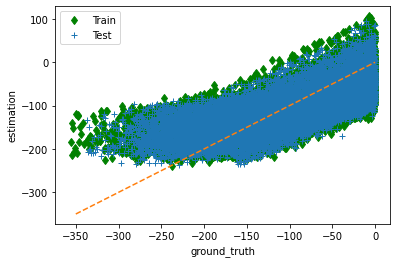

In [39]:
print('train score:', lasso_model.score(X_train, y_train))
print('test score:', lasso_model.score(X_test, y_test))

plt.plot(y_train, lasso_model.predict(X_train), 'gd')
plt.plot(y_test, lasso_model.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

# 4. Recurrent Deep Survival Machine
Dans cette partie nous allons utiliser l'architecture RDSM.

In [40]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append('../')
sys.path.append('auton_survival')
sys.path.append('auton_survival/auton_survival/')

from auton_survival import datasets

outcomes, features = datasets.load_support()
x, t, e = datasets.load_dataset('PBC', sequential = True)

$x$ est une liste qui contient des séries temporelles de 25 variables. $t$ est le temps avant événement ou avant censure, et $e$ l'indicateur de censure.

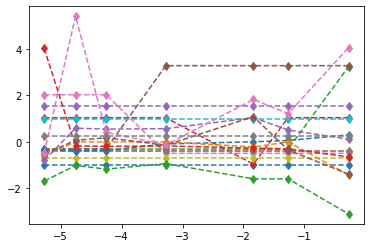

In [41]:
selected_unit = 3
plt.figure()
plt.plot(-t[selected_unit], x[selected_unit],'--d');

Nous montrons ici quelques graphes informatifs sur le dataset.

In [42]:
names = ['Penicillin',
 'Sex',
 'Ascites',
 'Hepatomegaly',
 'Spiders',
 'Edema despite diuretics',
 'Edema no diuretics',
 'histologic 2',
 'histologic 3',
 'histologic 4',
 'serBilir',
 'serChol',
 'albumin',
 'alkaline',
 'SGOT',
 'platelets',
 'prothrombin',
 'age']
FlattenDataSet = pd.DataFrame(np.concatenate(x), columns=names)
index_list = []
for idx, individual in enumerate(x):
    index_list.append(idx * np.ones(len(individual)))

FlattenDataSet['Index'] = np.concatenate(index_list)
    
FlattenTime = pd.DataFrame(np.concatenate(t))

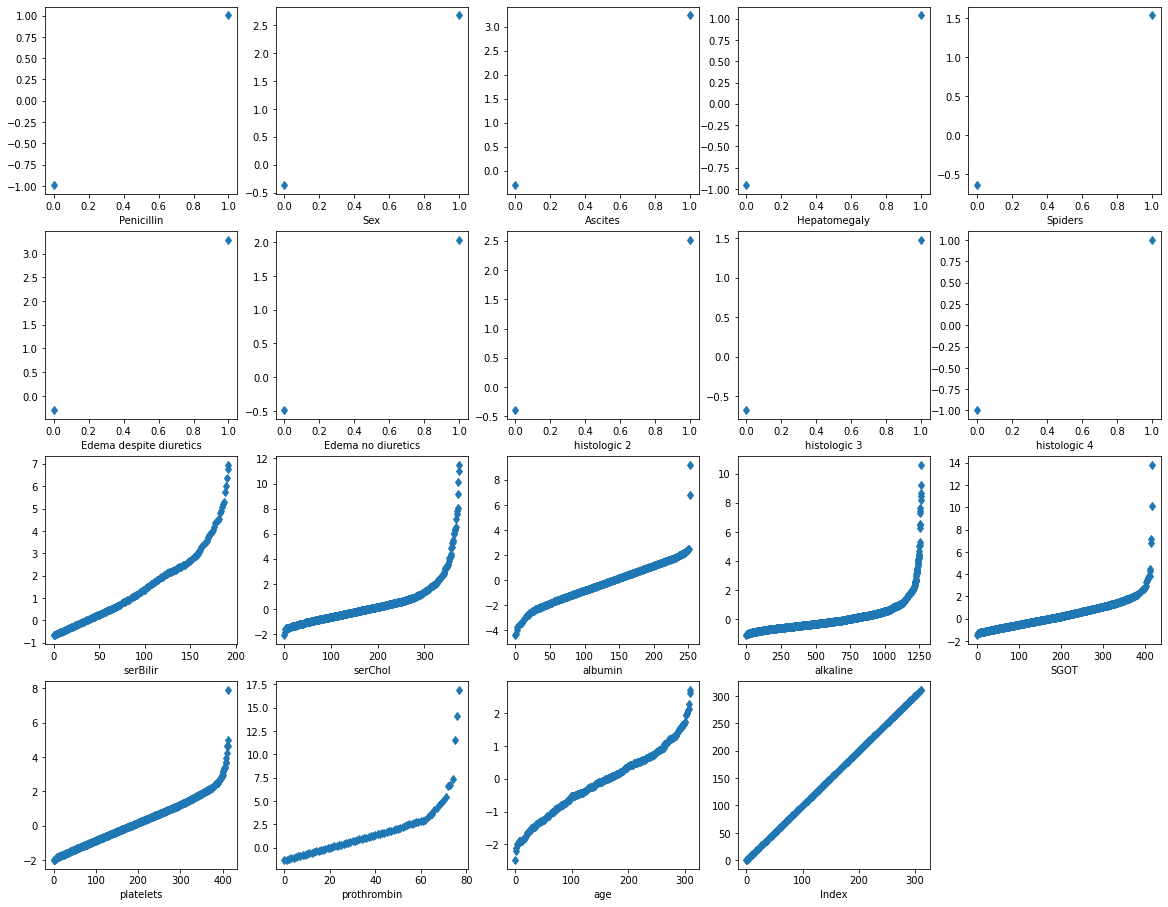

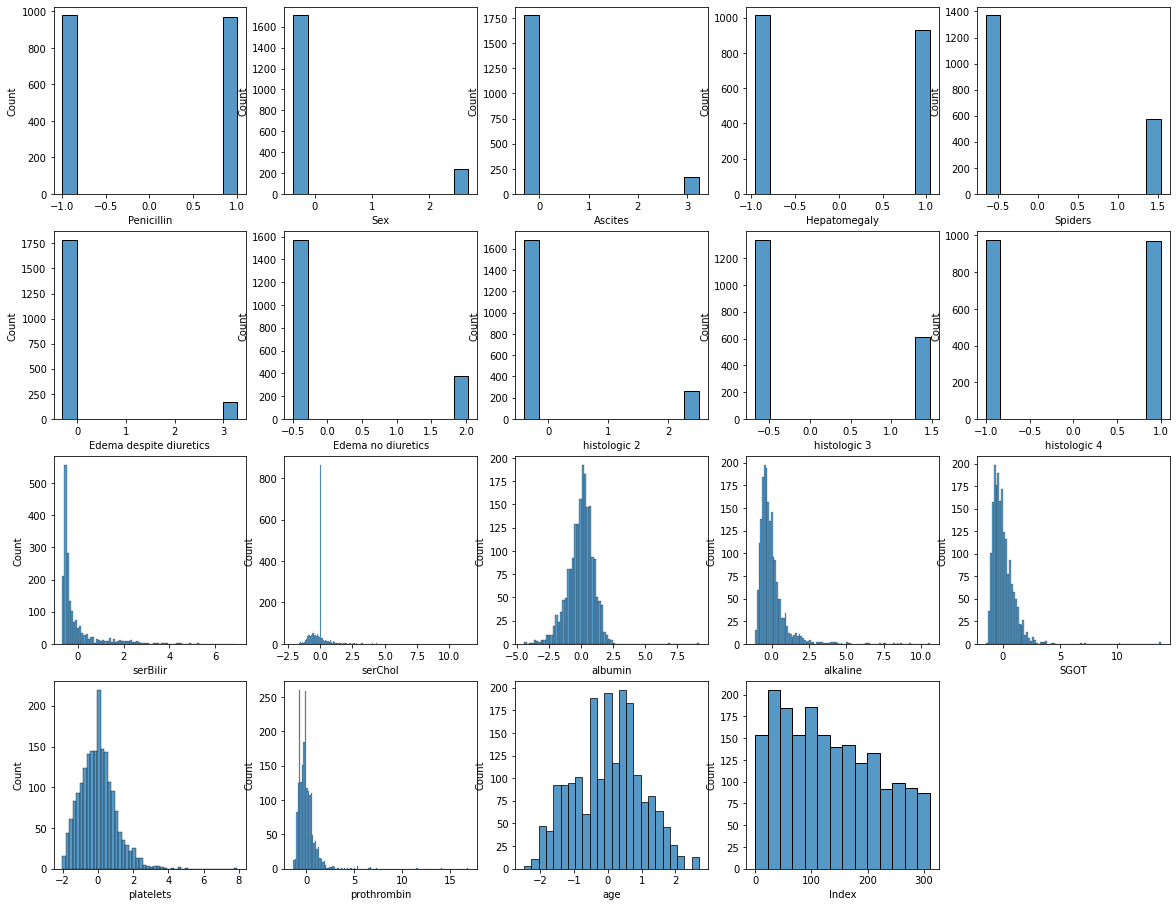

In [43]:
plt.figure(figsize=(20, 20))
for idp, k in enumerate(FlattenDataSet.keys()):
    plt.subplot(5, 5, idp+1)
    plt.plot(np.sort(FlattenDataSet[k].unique()),'d')
    plt.xlabel(k)
plt.tight_layout;

plt.figure(figsize=(20, 20))
for idp, k in enumerate(FlattenDataSet.keys()):
    plt.subplot(5, 5, idp+1)
    sns.histplot(FlattenDataSet[k])
    plt.xlabel(k)
plt.tight_layout;

In [44]:
# On calculera le brier score intégré avec les quantiles 0.25, 0.5, et 0.75
horizons = [0.25, 0.5, 0.75]
times = np.quantile(FlattenTime, horizons).tolist()


4.1 Faites quelques visualisations des temps avant événement sur le dataset. Un commentaire ?

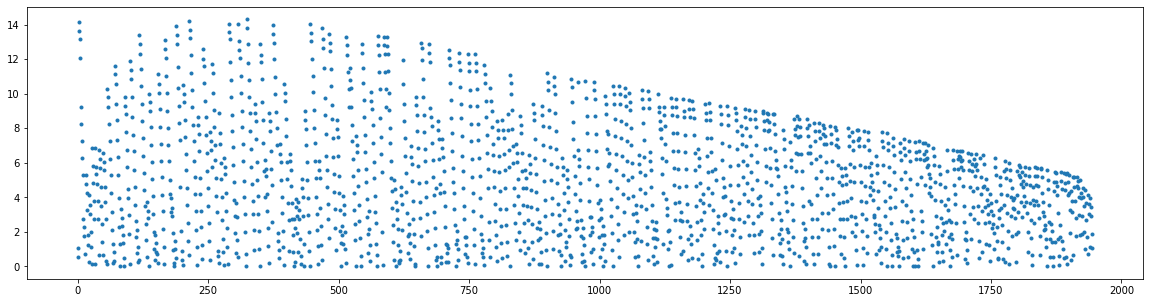

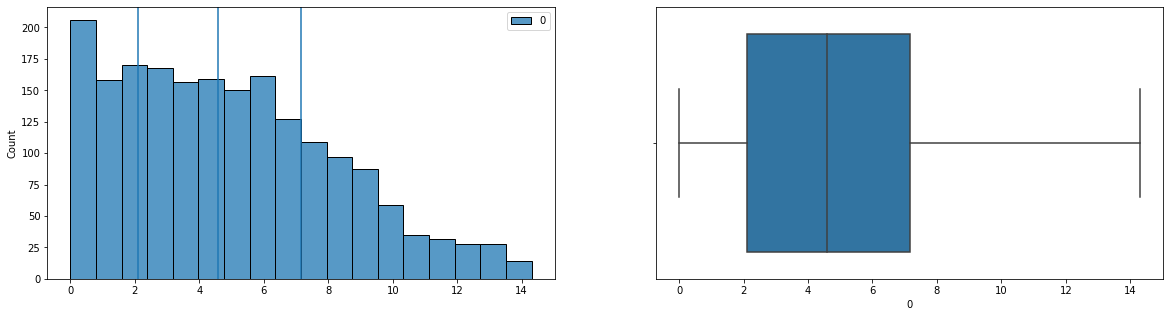

In [45]:
# Réponse
plt.figure(figsize=(20, 5))
plt.plot(FlattenTime, '.');
plt.figure(figsize=(20, 5))
plt.ylabel('time to event/censored time')
plt.subplot(1,2, 1)
sns.histplot(data=FlattenTime);
for value_t in times:
    plt.axvline(value_t)
plt.subplot(1,2, 2)
sns.boxplot(x=FlattenTime[0]);

4.2 Couper votre dataset en train / test / split. 

In [46]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3)
for train_index, test_index in gkf.split(x, groups=np.arange(len(x))):
    print("%s %s" % (len(train_index), len(test_index)))

#x_test = e_train, e_test, t_train, t_test = train_test_split(x, e, t, test_size=0.2, random_state=123)
x_train = np.array(x, dtype='object')[train_index]
x_test = np.array(x, dtype='object')[test_index]
e_train = np.array(e, dtype='object')[train_index]
e_test = np.array(e, dtype='object')[test_index]
t_train = np.array(t, dtype='object')[train_index]
t_test = np.array(t, dtype='object')[test_index]

208 104
208 104
208 104


4.3 Comparez deux architectures identiques entre lognormal & weibull.

In [47]:
from auton_survival.models.dsm import DeepRecurrentSurvivalMachines

In [48]:
param_setup_lognormal = {'k' : 3,
              'distribution' : 'LogNormal',
              'learning_rate' : 1e-3,
              'hidden': 100,
              'layers': 2,
              'typ': 'LSTM',
             }
param_setup_Weibull = {'k' : 3,
              'distribution' : 'Weibull',
              'learning_rate' : 1e-3,
              'hidden': 100,
              'layers': 2,
              'typ': 'LSTM',
             }

def learn(param):
    model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])

    model.fit(x_train, t_train, e_train, iters=10, learning_rate = param['learning_rate']);
    return model

model_lognormal = learn(param_setup_lognormal)
model_weibull = learn(param_setup_Weibull)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.35it/s]


In [49]:
print('tested times:', times)
et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                 dtype = [('e', bool), ('t', float)])
et_train_df = pd.DataFrame(et_train)
et_test_df = pd.DataFrame(et_test)
print('train t min', et_train_df['t'].min(), et_train_df['t'].max())
print('test t min', et_test_df['t'].min(), et_test_df['t'].max())

tested times: [2.1054648997918903, 4.5750739239951805, 7.159675829591502]
train t min 0.0027379257474500207 14.3056620304457
test t min 0.0027379257474500207 14.2153104807798


In [50]:
from sksurv.metrics import integrated_brier_score

def evaluate(model):
    out_survival = model.predict_survival(x_test, times)
    ibs = integrated_brier_score(et_train, et_test, out_survival, times)
    return ibs

In [51]:
print('LogNormal:', evaluate(model_lognormal))
print('Weibull:', evaluate(model_weibull))

LogNormal: 0.16613945723162843
Weibull: 0.15531085741062392
